# Imports

In [15]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py
import helper_functions
import cl_data_maker
importlib.reload(cl_data_maker)

<module 'cl_data_maker' from '/Users/ilyadavidson/Stanford_Internship/judge_project/cl_data_maker.py'>

In [1]:
from data_loading import build_cap_dataset, _load_mapping, court_listener_cleaner, promotion_info_judges, scrape_third_circuit
from helper_functions import judge_name_to_id
import json
import pandas as pd
from typing import Dict, List, Optional
from api_call import load_case_results
import numpy as np
import os

import pyarrow.dataset as ds
import re, pandas as pd, unicodedata
import pyarrow.compute as pc
import tiktoken
import re
import unicodedata
import statsmodels.api as sm
from typing import Optional
from helper_functions import norm_id
from typing import Dict, List, Optional
import re, unicodedata
from functools import lru_cache
from cl_data_maker import cl_loader, extract_district_judge_info

# Data loading

In [ ]:
judges      = pd.read_csv("data/judge_info.csv")
judges      = promotion_info_judges(judges)
cap_data    = build_cap_dataset()
cl          = cl_loader(judges) # get all the datapoints that scraper can find district judge for

def cap_data_cleaner(
    cap_df:             pd.DataFrame,
    mapping_path:       str = "appellate_matches2.json",   # appellate_custom_id -> district_unique_id
    api_path:           str = "batch_runs/api_responses.jsonl",
    *,
    id_col:             str = "unique_id",
    judge_name_col:     str = "opinion_author_clean",
    judge_id_col:       str = "opinion_author_id",
    case_name_col:      str = "name",
    docket_col:         str = "docket_number",
    opinion_text_col:   str = "opinion_text",
    decision_date_col:  str = "decision_date",
) -> pd.DataFrame:
    """
    Cleans CAP data and merges in district judge information and API answers.
    """

    app_to_dct             = _load_mapping(mapping_path)
    map_df                 = pd.DataFrame(list(app_to_dct.items()), columns=["custom_id", "district_uid"]).astype(str)

    # Keep only the original appellate cases present in mapping (keep their appellate metadata)
    out                    = cap_df.copy()
    out[id_col]            = out[id_col].astype(str)
    out                    = out[out[id_col].isin(map_df["custom_id"])].copy()

    # Attach appropriate district judge
    district_lookup = (
        cap_df[[id_col, judge_name_col, judge_id_col]]
        .drop_duplicates(subset=[id_col])
        .rename(columns={id_col:            "district_uid",
                         judge_name_col:    "district judge",
                         judge_id_col:      "district judge id"})
    )
    out = (
        out.merge(map_df, left_on=id_col, right_on="custom_id", how="left")
           .merge(district_lookup, on="district_uid", how="left")
    )

    # Get API answers
    api_answers                 = load_case_results(api_path) 
    api_answers                 = api_answers.copy()
    api_keys: List[str] = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")
    out[id_col]                 = "CAP_" + out["custom_id"].astype(str)

    out["district judge id"]    = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64") # 5.0 -> 5

    base_cols                   = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols                = {"lower_judge_first", "lower_judge_last"}
    api_cols                    = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols                   = [c for c in base_cols if c in out.columns] + api_cols

    return out[keep_cols].reset_index(drop=True)

cap_clean = cap_data_cleaner(cap_data)
thrd_judges = judges[judges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

/Users/ilyadavidson/Stanford_Internship/judge_project/data_loading.py:359: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aj["nomination date"] = pd.to_datetime(aj["nomination date"], errors="coerce")


Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


/Users/ilyadavidson/Stanford_Internship/judge_project/cl_data_maker.py:445: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['is_appellate'] = 1
/Users/ilyadavidson/Stanford_Internship/judge_project/cl_data_maker.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['unique_id'] = 'CL_' + cl_clean.index.astype(str)


In [197]:
df = scrape_third_circuit(limit=None, out_csv="third_circuit_cases.csv", checkpoint_every=200)

/Users/ilyadavidson/Stanford_Internship/judge_project/data_loading.py:408: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup=BeautifulSoup(h or "","html.parser")


In [54]:
cl.columns

Index(['_cid', 'name', 'docket_number', 'decision_date', 'opinion_text',
       'district judge', 'district judge id', 'is_appellate', 'unique_id',
       'overlap_by_substring'],
      dtype='object')

In [24]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = cap_clean["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 9429
Overlap by substring with CAP: 476
No overlap with CAP: 8953


In [2]:
from openai import OpenAI
client = OpenAI()

batch = client.batches.retrieve("batch_68e808059cf8819084f829f89f374e37")
print(batch.status)

in_progress


In [8]:
from scr.jp.cap.linking import match_appellates
from scr.jp.cap.data_loading    import build_cap_dataset
df      = build_cap_dataset(parquet_root= "data/parquet_files")
print(f"[CAP] rows: {len(df):,}")

# 2. Appellate mapping to district cases and get judge
########################################################
df      = match_appellates(df, path="data/artifacts/cap/appellate_matches2.json")

print(f"Appellate matching done, kept {len(df)} cases.")

Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet
[CAP] rows: 97,431
Appellate matching done, kept 3909 cases.


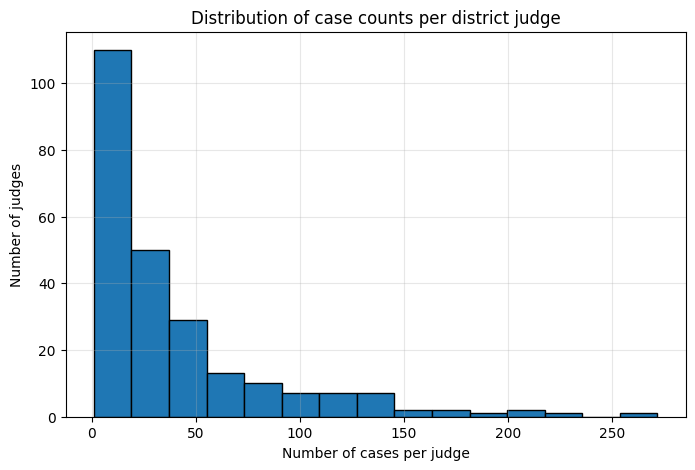

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming your dataframe is cl_extracted (or similar)
df = cl.copy()

# count cases per judge id
cases_per_judge = (
    df['district judge id']
    .dropna()
    .astype(int)
    .value_counts()
)

# make a histogram (binning number of cases)
plt.figure(figsize=(8,5))
plt.hist(cases_per_judge, bins=15, edgecolor='black')
plt.xlabel("Number of cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of case counts per district judge")
plt.grid(alpha=0.3)
plt.show()

In [145]:
def load_case_results(path: str = "batch_runs/cl_scrape_results.jsonl") -> pd.DataFrame:
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            if rec.get("error"):
                continue
            try:
                content = rec["response"]["body"]["choices"][0]["message"]["content"]
                obj = json.loads(content)  # parse the 9-key JSON
            except Exception:
                continue
            obj["custom_id"] = rec.get("custom_id")  # keep your custom_id
            records.append(obj)
    return pd.DataFrame.from_records(records)

def attach_api_to_cl_clean(
    cl_clean: pd.DataFrame,
    api_path: str = "batch_runs/cl_scrape_results.jsonl",
    *,
    id_col: str = "unique_id",
    case_name_col: str = "name",
    opinion_text_col: str = "opinion_text",
    docket_col: str = "docket_number",
    decision_date_col: str = "decision_date",
) -> pd.DataFrame:
    out = cl_clean.copy()

    # Mirror unique_id -> custom_id so your merge block stays identical
    out["custom_id"] = (
    out["unique_id"]
    .astype("string")
    .str.replace("CL_", "", regex=False)
)

    # === Use your exact merge logic ===
    api_answers                 = load_case_results(api_path)
    api_answers                 = api_answers.copy()
    api_keys: List[str]         = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")
    # DO NOT prefix CL ids (that's for CAP). Keep cl_clean's unique_id unchanged.
    # out[id_col]               = "CAP_" + out["custom_id"].astype(str)  # <-- intentionally NOT used

    if "district judge id" in out.columns:
        out["district judge id"] = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64")

    base_cols = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols = {"lower_judge_first", "lower_judge_last"}
    api_cols     = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols = [c for c in base_cols if c in out.columns] + api_cols
    return out[keep_cols].reset_index(drop=True)

In [42]:
cl.sample(1)

,_cid,name,docket_number,decision_date,opinion_text,district judge,district judge id,is_appellate,unique_id,overlap_by_substring
15717,595593,Caldwell v. Del Tufo,92-5056,1992-10-09,"980 F.2d 722\n\nCaldwell (Olin Jardu, Sr.)\nv....",brotman,279,1,CL_15717,False


In [39]:
cl[cl['unique_id']=='CL_7190']

,_cid,name,docket_number,decision_date,opinion_text,district judge,district judge id,is_appellate,unique_id,overlap_by_substring


In [ ]:
# cl_final = attach_api_to_cl_clean(cl_clean)

KeyError: 'unique_id'

In [53]:
cl

,_cid,name,docket_number,decision_date,opinion_text,district judge,district judge id,is_appellate,unique_id,overlap_by_substring
0,10692010,NRA Group LLC v. Nicole Durenleau,24-1123,2025-10-07,PRECEDE...,wilson,7330451,1,CL_0,False
1,10691427,Andrew Perrong v. Matthew Bradford,24-1925,2025-10-06,PRECEDENTIA...,wolson,6385006,1,CL_1,False
2,10691426,Novo Nordisk Inc v. Secretary US Dept & Health...,24-2510,2025-10-06,PRECEDEN...,quraishi,10236621,1,CL_2,False
3,10679495,United States v. Natalya Shvets,22-2683,2025-09-29,PRECEDEN...,robreno,2033,1,CL_3,False
4,10678447,Bobrick Washroom Equipment Inc v. Scranton Pro...,23-2577,2025-09-26,PRECED...,mariani,3397,1,CL_4,False
...,...,...,...,...,...,...,...,...,...,...
32777,8859980,Harper v. Harper,NaN,1892-12-05,"BUFFINGTON, District Judge.\n\nThis is an appe...",buffington,313,1,CL_32777,False
32780,8859978,New Chester Water Co. v. Holly Manuf'g Co.,No. 7,1892-11-14,"WALES, District Judge,\n\n(after stating the f...",wales,2477,1,CL_32780,True
32784,8859047,Yardley v. Clothier,NaN,1892-08-16,"Wales, District Judge.\n\nThe case stated show...",wales,2477,1,CL_32784,False
32785,8859046,In re Manderson,NaN,1892-08-16,"Wales, District Judge.\n\nProceedings were ins...",wales,2477,1,CL_32785,False


In [156]:
cl_extracted.to_csv('cl_extracted.csv', index=False)

In [177]:
cl_extracted

,name,docket_number,decision_date,opinion_text,district judge,district judge id
0,NRA Group LLC v. Nicole Durenleau,24-1123,2025-10-07,PRECEDE...,wilson,7330451
1,Andrew Perrong v. Matthew Bradford,24-1925,2025-10-06,PRECEDENTIA...,wolson,6385006
2,Novo Nordisk Inc v. Secretary US Dept & Health...,24-2510,2025-10-06,PRECEDEN...,quraishi,10236621
3,United States v. Natalya Shvets,22-2683,2025-09-29,PRECEDEN...,robreno,2033
4,Bobrick Washroom Equipment Inc v. Scranton Pro...,23-2577,2025-09-26,PRECED...,mariani,3397
...,...,...,...,...,...,...
8802,Shadis v. Beal,82-1044,1982-11-10,"692 F.2d 924\n\nJack SHADIS, Belle Feinberg, M...",teitelbaum,2352
8803,United States v. Michael Schaefer and Clairton...,81-3099,1982-10-22,*641\n \n\n OPINION OF THE COURT\n \n\n FU...,fullam,804
8804,Middlesex County Utilities Authority v. Boroug...,82-5116,1982-10-12,"OPINION OF THE COURT\n \n\n POLLAK, District ...",pollak,1904
8805,Multi-Family Council Of Southeastern Pennsylva...,82-1211,1982-10-08,689 F.2d 469\n\nMULTI-FAMILY COUNCIL OF SOUTHE...,meanor,1606


In [178]:
cl_extracted['unique_id'] = 'CL_' + cl_extracted.index.astype(str)

In [179]:
cl_final = attach_api_to_cl_clean(cl_extracted)

In [180]:
cl_final = cl_final[cl_final['opinion'].notna()]

In [45]:
cl_final

NameError: name 'cl_final' is not defined

In [182]:
def merge_cap_and_cl(cap: pd.DataFrame, cl: pd.DataFrame) -> pd.DataFrame:
    cap = cap.copy()
    cl  = cl.copy()

    # Normalize dockets for reliable matching
    cap["_dkey"] = cap["docket_number"].astype(str).str.strip()
    cl["_dkey"]  = cl["docket_number"].astype(str).str.strip()

    # Build fast lookup (first non-null per docket) for IDs and names from CL
    cl_id_map   = (cl[["_dkey", "district judge id"]]
                   .dropna(subset=["district judge id"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge id"])
    cl_name_map = (cl[["_dkey", "district judge"]]
                   .dropna(subset=["district judge"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge"])

    # Fill CAP's missing judge id/name from CL where dockets match
    miss_id = cap["district judge id"].isna()
    cap.loc[miss_id, "district judge id"] = cap.loc[miss_id, "_dkey"].map(cl_id_map)

    if "district judge" in cap.columns:
        miss_name = cap["district judge"].isna()
        cap.loc[miss_name, "district judge"] = cap.loc[miss_name, "_dkey"].map(cl_name_map)

    # Append CL rows that don't overlap by docket
    non_overlap_cl = cl[~cl["_dkey"].isin(cap["_dkey"])]
    non_overlap_cl = non_overlap_cl.reindex(columns=cap.columns, fill_value=np.nan)

    out = pd.concat([cap, non_overlap_cl], ignore_index=True)
    return out.drop(columns=["_dkey"], errors="ignore")

In [183]:
full_data = merge_cap_and_cl(cap_clean, cl_final)

In [184]:
full_data = full_data[full_data['district judge id'].notna()]

In [185]:
full_data

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level
1,CAP_87739,"DIMENSIONAL COMMUNICATIONS, INC. v. OZ OPTICS,...","OPINION OF THE COURT\nPOLLAK, District Judge.\...",No. 04-1817,bassler,114,2005-08-12 00:00:00,affirmed,contract,abuse of discretion,company,company,1.0,low
2,CAP_87689,"Martin BRODY; Florence Brody; MFB Partners, L....","OPINION OF THE COURT\nSMITH, Circuit Judge.\nW...",No. 04-1376,joyner,1212,2005-08-29 00:00:00,reversed and remanded,civil,legal error,group of individuals,male,1.0,low
3,CAP_87025,LAW OFFICES OF CHRISTOPHER S. LUCAS & ASSOCIAT...,"OPINION OF THE COURT\nRENDELL, Circuit Judge.\...",No. 04-2695,jones,2946,2005-04-04 00:00:00,affirmed,civil,legal error,male,group of individuals,2.0,medium
4,CAP_87033,"Cynthia A. EBBERT, Appellant, v. DAIMLERCHRYSL...","OPINION OF THE COURT\nGREENBERG, Circuit Judge...",No. 04-2143,sleet,2772,2005-04-14 00:00:00,affirmed,civil,insufficient evidence,female,company,2.0,high
5,CAP_87087,"Ted A. MCCRACKEN, Appellant, v. Frank P. MURPH...",OPINION\nPER CURIAM.\nPro se appellant Ted A. ...,No. 04-3454,robreno,2033,2005-04-29 00:00:00,affirmed,tort,insufficient evidence,male,group of individuals,1.0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728,CL_7213,Teamsters Local Union No. 776 v. Rite Aid Corp...,902 F.2d 1562\n\n135 L.R.R.M. (BNA) 2096\n\nTe...,89-5859,kosik,1312,1990-04-09,affirmed,criminal,legal error,group of individuals,other,1.0,low
7729,CL_7222,"St. John Mortgage Company, Inc. v. United Stat...","OPINION OF THE COURT\n \n\n LIFLAND, District...",89-1388,lifland,1397,1990-04-05,remanded,labor,procedural error,group of individuals,other,2.0,medium
7730,CL_7233,"Appeal of Pandrol, Inc","899 F.2d 1218\n\nAppeal of Pandrol, Inc.\n\nNO...",89-5221,brotman,279,1990-03-28,affirmed,civil,legal error,company,company,1.0,medium
7731,CL_7235,"Appeal of Profaizer (Anthony A., Roberta R.)",899 F.2d 1219\n\nAppeal of Profaizer (Anthony ...,89-3473,mccune,1538,1990-03-27,vacated,bankruptcy,procedural error,group of individuals,group of individuals,1.0,low


In [193]:
import pandas as pd, numpy as np

def compute_overturns(judges: pd.DataFrame, full_data: pd.DataFrame) -> pd.DataFrame:
    df = full_data.copy()
    df["judge id"]      = pd.to_numeric(df["district judge id"], errors="coerce").astype("Int64")
    df["opinion"]       = df["opinion"].astype(str).str.lower()
    df["decision_date"] = pd.to_datetime(df["decision_date"], errors="coerce")

    j = judges.copy()
    j["promotion_date"] = pd.to_datetime(j["promotion_date"], errors="coerce")
    j["cutoff"]         = j["promotion_date"] - pd.DateOffset(months=3)

    m = df.merge(j[["judge id","cutoff"]], on="judge id", how="inner")
    m = m[m["decision_date"].notna() & (m["cutoff"].isna() | (m["decision_date"] <= m["cutoff"]))]

    counts = m.groupby("judge id", dropna=True).agg(
        appealed_cases=("unique_id","count"),
        overturned_appealed_cases=("opinion", lambda x: (x != "affirmed").sum())
    )

    out = j.merge(counts, on="judge id", how="left")
    out[["appealed_cases","overturned_appealed_cases"]] = out[["appealed_cases","overturned_appealed_cases"]].fillna(0).astype(int)
    out["overturnrate"] = np.where(out["appealed_cases"] > 0,
                                   out["overturned_appealed_cases"] / out["appealed_cases"], np.nan)
    return out

In [194]:
feature_dataset = compute_overturns(judges, full_data)

In [195]:
feature_dataset = feature_dataset[feature_dataset["appealed_cases"] > 15]

In [196]:
# Regression analysis with gender and ethnicity
y = feature_dataset["is_promoted"].astype(float)  
X = pd.DataFrame({
    "overturnrate": pd.to_numeric(feature_dataset["overturnrate"], errors="coerce"),

})


mask = ~(y.isna() | X.isna().any(axis=1))
y_clean = y.loc[mask]
X_clean = X.loc[mask]

X_clean = sm.add_constant(X_clean, has_constant="add")

logit_model = sm.Logit(y_clean, X_clean).fit(maxiter=100)
print("=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(logit_model.summary())

ols_model = sm.OLS(y_clean, X_clean).fit(maxiter=100)
print("\n=== OLS Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.251307
         Iterations 7
=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===
                           Logit Regression Results                           
Dep. Variable:            is_promoted   No. Observations:                  174
Model:                          Logit   Df Residuals:                      172
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Oct 2025   Pseudo R-squ.:                 0.05404
Time:                        19:05:28   Log-Likelihood:                -43.727
converged:                       True   LL-Null:                       -46.225
Covariance Type:            nonrobust   LLR p-value:                   0.02541
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0750    